In [2]:
# === Imports ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# === Step 1: Load and Transform Dataset ===
file_path = "vroegtijdig-schoolverlaten-woonplaats-dataset-2022-2023.xlsx"
bad_df = pd.read_excel(file_path)

def transform_dataset(df):
    transformed_rows = []
    for _, row in df.iterrows():
        for i in range(row['vsv_noemer']):
            new_row = row.copy()
            new_row['vsv_teller'] = 1 if i < row['vsv_teller'] else 0
            transformed_rows.append(new_row)
    result_df = pd.DataFrame(transformed_rows)
    return result_df.drop(columns=['vsv_noemer'])

df = transform_dataset(bad_df)
df.drop(columns=['schooljaar'], inplace=True)  # Drop useless column

# === Step 2: Define Features & Target ===
X = df.drop(columns=['vsv_teller'])
y = df['vsv_teller']

In [3]:
# === Step 3: Preprocessing ===
categorical_cols = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_cols)
], remainder='passthrough')

In [4]:
# === Step 4: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [5]:
# === Step 5: Evaluation Function ===
def evaluate(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Dropout', 'Dropout'],
                yticklabels=['No Dropout', 'Dropout'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [11]:
# === Step 6: Baseline Random Forest ===
model = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
model.fit(X_train, y_train)
y_pred_base = model.predict(X_test)

Classification Report (Before Resampling):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12444
           1       0.90      0.70      0.79      1890

    accuracy                           0.95     14334
   macro avg       0.93      0.84      0.88     14334
weighted avg       0.95      0.95      0.95     14334



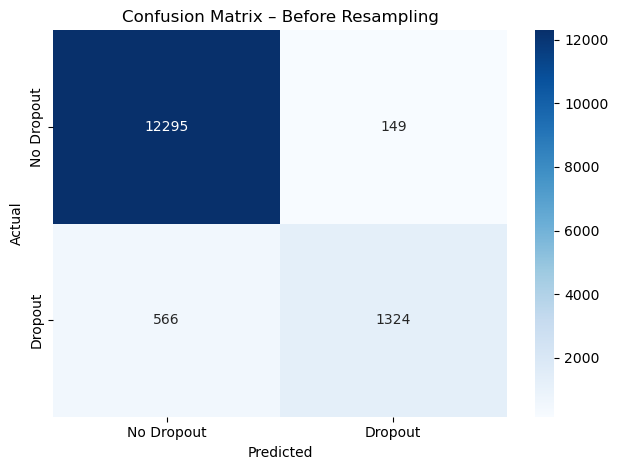

In [12]:
# === Step 7: Evaluate Before Resampling ===
print("Classification Report (Before Resampling):")
print(classification_report(y_test, y_pred_base))
evaluate(y_test, y_pred_base, "Confusion Matrix – Before Resampling")

In [8]:
# === Step 8: Resampling with SMOTE ===
resampled_pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])
resampled_pipeline.fit(X_train, y_train)
y_pred_smote = resampled_pipeline.predict(X_test)

Classification Report (After Resampling):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     12444
           1       0.86      0.73      0.79      1890

    accuracy                           0.95     14334
   macro avg       0.91      0.86      0.88     14334
weighted avg       0.95      0.95      0.95     14334



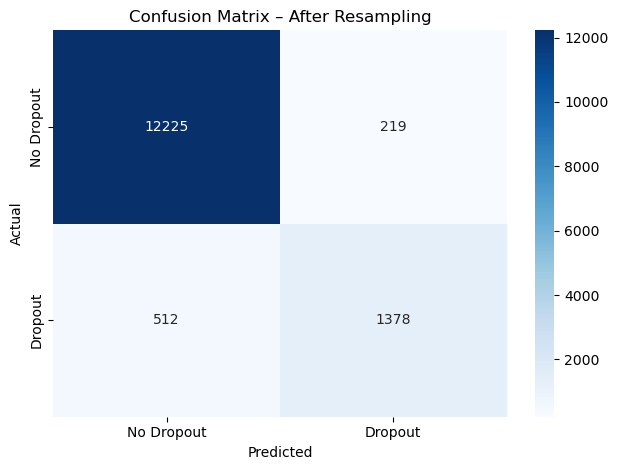

In [9]:
# === Step 9: Evaluate After Resampling ===
print("Classification Report (After Resampling):")
print(classification_report(y_test, y_pred_smote))
evaluate(y_test, y_pred_smote, "Confusion Matrix – After Resampling")